Installation of missing libraries. In this case we need to install transformers.

In [2]:
!pip install transformers

     |████████████████████████████████| 1.1MB 4.5MB/s 
     |████████████████████████████████| 1.1MB 23.0MB/s 
     |████████████████████████████████| 3.0MB 40.4MB/s 
     |████████████████████████████████| 890kB 53.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=6b12fa01f047d2259b30b374b17b094186f2d248009197f3d6aee27a3ec4ec2d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


Import required packages.

In [3]:
import copy
from pathlib import Path
import time
from typing import (Dict,
                    List,
                    Optional,
                    Tuple,
                    Union)

import bson
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (average_precision_score,
                             confusion_matrix,
                             precision_recall_curve)
import torch
from torch.utils.data import (DataLoader,
                              RandomSampler,
                              SequentialSampler,
                              TensorDataset)
import transformers
from transformers import (XLMRobertaForSequenceClassification,
                          XLMRobertaTokenizer)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Dataset download & load

In [5]:
!wget https://ml-coding-test.s3.amazonaws.com/claims.bson

--2020-10-17 11:52:03--  https://ml-coding-test.s3.amazonaws.com/claims.bson
Resolving ml-coding-test.s3.amazonaws.com (ml-coding-test.s3.amazonaws.com)... 52.218.89.10
Connecting to ml-coding-test.s3.amazonaws.com (ml-coding-test.s3.amazonaws.com)|52.218.89.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5735425 (5.5M) [binary/octet-stream]
Saving to: ‘claims.bson’

claims.bson         100%[===================>]   5.47M  4.46MB/s    in 1.2s    

2020-10-17 11:52:05 (4.46 MB/s) - ‘claims.bson’ saved [5735425/5735425]



In [83]:
FILE_PATH = '/content/claims.bson'

with open(FILE_PATH,'rb') as f:
    data = bson.decode_all(f.read())

Mongo dump is loaded as a pandas DataFrame.

In [84]:
df = pd.DataFrame(data)

Problem´s target variable is defined.

In [86]:
target = 'claim'

First of all, we need to split the data in three differents sets to simulate a real pipeline and also to avoid any syntom of data leackage on the test phase. In this case I have splitted the raw data in Train 80%, Validation 10% and Test 10% using a stratified manner to mantain the class ratio between each of them.

In [87]:
def get_split_sets(df: pd.DataFrame,
                   target: str,
                   val_test_size: float=0.2, # ratio for the val + test (10% + 10%)
                   test_size: float=0.5,     # ratio between val and test (20% * 0.5)
                   random_state: int=31):
    sss_train_val = StratifiedShuffleSplit(test_size=val_test_size, random_state=random_state)

    X = df.loc[:, df.columns != target]
    y = df.loc[:, target]

    train_idxs, val_test_idxs = [*sss_train_val.split(X, y)][0]

    X_val_test = X.loc[val_test_idxs].reset_index(drop=True)
    y_val_test = y.loc[val_test_idxs].reset_index(drop=True)

    sss_test = StratifiedShuffleSplit(test_size=test_size, random_state=random_state)

    val_idxs, test_idxs = [*sss_test.split(X_val_test, y_val_test)][0]

    X_train = X.loc[train_idxs].reset_index(drop=True)
    y_train = y.loc[train_idxs].reset_index(drop=True)

    X_val = X_val_test.loc[val_idxs]
    y_val = y_val_test.loc[val_idxs]

    X_test = X_val_test.loc[test_idxs]
    y_test = y_val_test.loc[test_idxs]

    df_train = pd.concat([X_train, y_train], axis=1)
    df_val = pd.concat([X_val, y_val], axis=1)
    df_test = pd.concat([X_test, y_test], axis=1)

    return df_train, df_val, df_test

In [88]:
df_train, df_val, df_test = get_split_sets(df=df,
                                           target=target,
                                           val_test_size=0.2, # ratio for the val + test (10% + 10%)
                                           test_size=0.5,     # ratio between val and test (20% * 0.5)
                                           random_state=31)

In [89]:
for set_name, set_type, in zip(['Train', 'Val', 'Test'],
                               [df_train, df_val, df_test]):
  print(f'{set_name} shape: {set_type.shape}, Positive %: {(set_type[target].value_counts()[1]/set_type[target].shape[0])*100:.4f}%')

Train shape: (11482, 5), Positive %: 7.4203%
Val shape: (1435, 5), Positive %: 7.3868%
Test shape: (1436, 5), Positive %: 7.4513%


# Exploratory Data Analysis (EDA)

We can do a very simple EDA over the raw training data. In this case the dataset has an identifier column, three columns with each language text and a final column named claim which indicates that the text can be verified (1) or not (0).

In [11]:
df_train.head()

,_id,text_es,text_en,text_fr,claim
0,5f80940cf95f926ca81a48bd,Han sido validados para los medios públicos p...,They have been validated for the public media...,Ils ont été validés pour les médias publics p...,1
1,5f80940cf95f926ca81a4a28,"Señora Belarra, yo creo que el Gobierno está ...","Mrs Belarra, I think the government is coming...","Madame Belarra, je pense que le gouvernement ...",0
2,5f80940df95f926ca81a5302,Eso es cierto que en el mes de junio todavía ...,That is true that in June we still have about...,"Il est vrai qu’en juin, nous avons encore env...",1
3,5f80940cf95f926ca81a3799,Acceda a todos los programas en RD Web.,Access all programs in RD Web.,Accédez à tous les programmes sur RD Web.,0
4,5f80940cf95f926ca81a4f52,Me consta.,I know.,Je sais.,0


In [12]:
df_train.shape

(11482, 5)

In [13]:
df_train.describe(include=['O'])

,_id,text_es,text_en,text_fr
count,11482,11482,11482,11482
unique,11482,11110,11060,11029
top,5f80940df95f926ca81a5a2b,Buenos días.,Good morning.,Bonjour.
freq,1,52,61,65


No missing values are found.

In [14]:
df_train.isnull().sum()

_id        0
text_es    0
text_en    0
text_fr    0
claim      0
dtype: int64

As expected, _id column must be removed, since this column is just an identifier, so it does not provide any information.

In [15]:
df_train.drop('_id', axis=1, inplace=True)

Since we are going to use a BERT arquitecture as a model, we can take a look at the distribution of the number of tokens of each language to gain some insights.

In [16]:
xlmr_tokenizer = XLMRobertaTokenizer.from_pretrained('xlm-roberta-base')

In [17]:
def text_length(text, tokenizer):
  return len(tokenizer.encode(text,
                              add_special_tokens=True))

In [18]:
text_es_length = df_train['text_es'].apply(text_length, tokenizer=xlmr_tokenizer)
text_en_length = df_train['text_en'].apply(text_length, tokenizer=xlmr_tokenizer)
text_fr_length = df_train['text_fr'].apply(text_length, tokenizer=xlmr_tokenizer)

In [19]:
df_tokenized_length = pd.DataFrame({text_es_length.name: text_es_length,
                                    text_en_length.name: text_en_length,
                                    text_fr_length.name: text_fr_length})

In [20]:
df_tokenized_length['total'] = df_tokenized_length.sum(axis=1)

Text(0.5, 0, 'Language text')

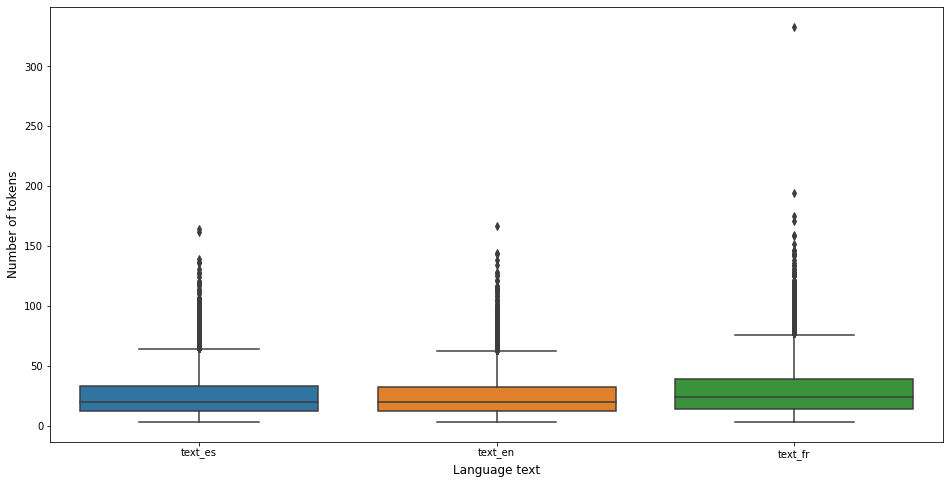

In [21]:
fig, ax = plt.subplots(figsize=(16,8))
sns.boxplot(data=df_tokenized_length.loc[:, df_tokenized_length.columns != 'total'], ax=ax)
ax.set_ylabel('Number of tokens', fontdict={'size': 12})
ax.set_xlabel('Language text', fontdict={'size': 12})

Text(0.5, 0, 'Total')

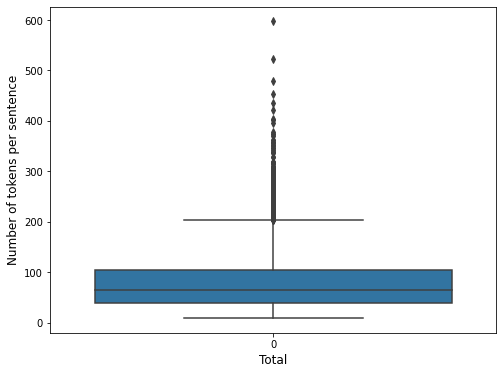

In [22]:
fig, ax = plt.subplots(figsize=(8,6))
sns.boxplot(data=df_tokenized_length.loc[:, 'total'], ax=ax)
ax.set_ylabel('Number of tokens per sentence', fontdict={'size': 12})
ax.set_xlabel('Total', fontdict={'size': 12})

In [23]:
quartiles = df_tokenized_length.quantile([0.25,0.5,0.75])
quartiles

,text_es,text_en,text_fr,total
0.25,12.0,12.0,14.0,38.0
0.50,20.0,20.0,24.0,65.0
0.75,33.0,32.0,39.0,104.0


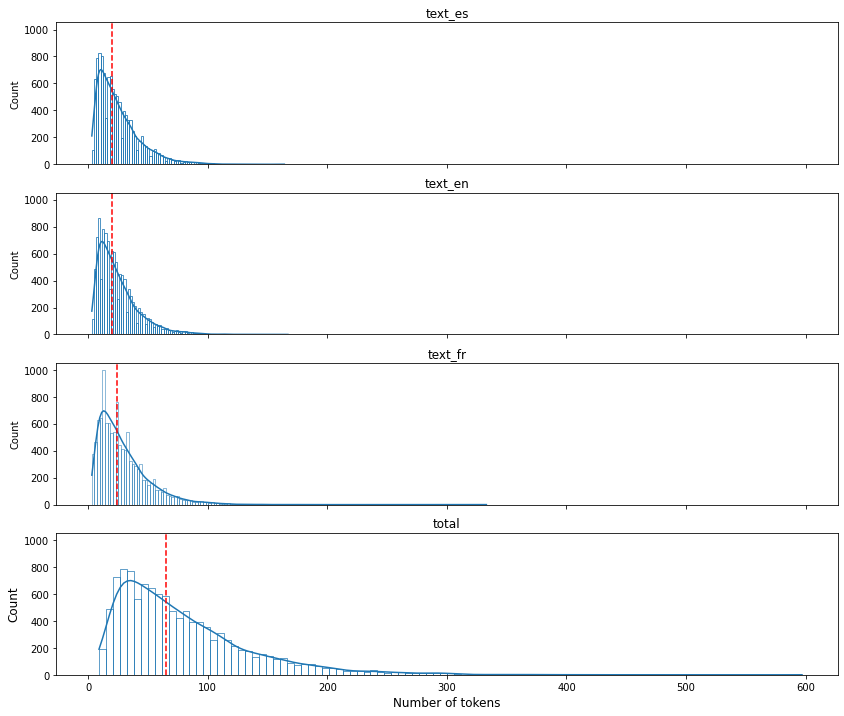

In [24]:
fig, axs = plt.subplots(4, figsize=(14, 12), sharex=True, sharey=True)
for ax, col in zip(axs, df_tokenized_length.columns):
  data = df_tokenized_length.loc[:, col]
  sns.histplot(data=data, kde=True, fill=False, ax=ax)
  ax.set_title(col)
  ax.axvline(x=np.median(data), color='r', ls='--', label='median')
plt.xlabel("Number of tokens", fontdict={'size': 12})
plt.ylabel("Count", fontdict={'size': 12})
plt.show()

From the figures above we can see that for each language the median is around 20 tokens per sentence for text_es and text_en, while for text_fr the median is around 24 tokens per sentence. The total median per sentence is 65 tokens.

Knowing that we have different sentence lengths a max value where the sentence will be truncated or padded to complete the length must be setted.

I propose to used the maximum value (which exclude outliers) for each language  given by Q3 (3rd quartile) + 1.5 * IQR (Interquartile range).

In [25]:
max_length = (quartiles.iloc[-1] + 1.5 * (quartiles.iloc[-1] - quartiles.iloc[0])).round().iloc[:-1].astype('int32').to_dict()
max_length

{'text_en': 62, 'text_es': 64, 'text_fr': 76}

To analize the target variable we can check the class distribution. Which clearly shows that we are dealing with an imbalanced problem.

In [26]:
df_train[target].value_counts() / df_train[target].shape[0]

0    0.925797
1    0.074203
Name: claim, dtype: float64

Text(-8.700000000000003, 0.5, 'Count')

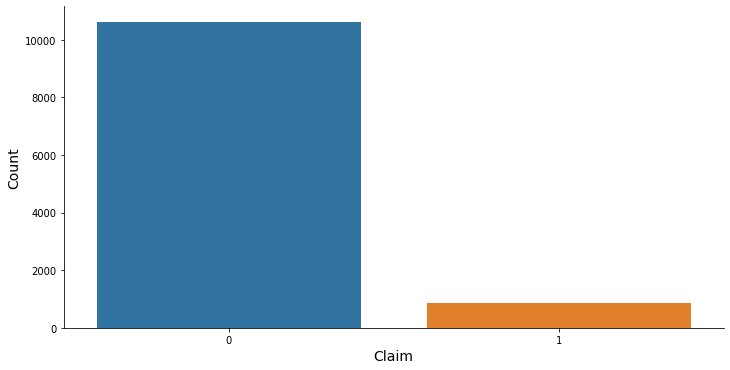

In [27]:
sns.catplot(x=target,
            kind="count",
            data=df_train,
            height=5,
            aspect=2)
plt.xlabel("Claim", fontdict={'size': 14})
plt.ylabel("Count", fontdict={'size': 14})

# Data preprocessing

In order to been able to use a BERT arquitecture we must tokenize each sentence. For this problem, we have three sentences per sample.

The next function takes a sample, tokenize each sentence (three in this case), applies the required padding or gets truncated to the max_length (each language has a different value) argument and the resulting ids and masks are added to a common list. This means that for each sample we have a concatenation of the three sentences ids and masks.

In [29]:
def tokenize_sample(sample: pd.Series,
                    max_length: Dict,
                    tokenizer: transformers.tokenization_utils.PreTrainedTokenizer,
                    **kwargs: Dict):
  input_ids = []
  attn_masks = []
  for col, text in sample.items():
      encoded = tokenizer.encode_plus(text,
                                      add_special_tokens=kwargs.get('add_special_tokens', True),
                                      max_length=max_length.get(col, 100),
                                      truncation=kwargs.get('truncation', True),
                                      padding=kwargs.get('padding', 'max_length'))
      input_ids.extend(encoded['input_ids'])
      attn_masks.extend(encoded['attention_mask'])
  return torch.tensor(input_ids), torch.tensor(attn_masks)

The next function just iterate through a given dataset and applies the explained procedure to each sample. Finally it outputs an ids tensor, a mask tensor and the labels.

In [30]:
def preprocess_set(X: pd.DataFrame,
                   y: pd.DataFrame,
                   max_length: Dict,
                   tokenizer: transformers.tokenization_utils.PreTrainedTokenizer,
                   **kwargs: Dict):

  input_ids = []
  attn_masks = []

  for row in X.itertuples(index=False):
      row_input_ids, row_attn_masks = tokenize_sample(sample=pd.Series(row),
                                                      max_length=max_length,
                                                      tokenizer=tokenizer,
                                                      **kwargs)
      input_ids.append(row_input_ids)
      attn_masks.append(row_attn_masks)

  input_ids = torch.stack(input_ids)
  attn_masks = torch.stack(attn_masks)
  labels = torch.tensor(y.to_numpy(), dtype=torch.float32).unsqueeze(1)

  return input_ids, attn_masks, labels

To avoid GPU memory problems, a batch size of 64 is setted.

In [31]:
batch_size = 64

For each dataset a Dataloader is created, the only difference between them is that the train dataloader takes samples in random order, while validation and test dataloader take samples in sequential order.

In [32]:
X_train = df_train.loc[:, df_train.columns != target]
y_train = df_train[target]

train_input_ids, train_attn_masks, train_labels = preprocess_set(X=X_train,
                                                                 y=y_train,
                                                                 max_length=max_length,
                                                                 tokenizer=xlmr_tokenizer)

train_dataset = TensorDataset(train_input_ids,
                              train_attn_masks,
                              train_labels)

train_dataloader = DataLoader(train_dataset,
                              sampler=RandomSampler(train_dataset),
                              batch_size=batch_size)

Drop _id for validation and test sets.

In [33]:
df_val.drop('_id', axis=1, inplace=True)
df_test.drop('_id', axis=1, inplace=True)

In [34]:
X_val = df_val.loc[:, df_val.columns != target]
y_val = df_val[target]

val_input_ids, val_attn_masks, val_labels = preprocess_set(X=X_val,
                                                           y=y_val,
                                                           max_length=max_length,
                                                           tokenizer=xlmr_tokenizer)

val_dataset = TensorDataset(val_input_ids,
                            val_attn_masks,
                            val_labels)

val_dataloader = DataLoader(val_dataset,
                            sampler=SequentialSampler(val_dataset),
                            batch_size=batch_size*4)

In [35]:
X_test = df_test.loc[:, df_test.columns != target]
y_test = df_test[target]

test_input_ids, test_attn_masks, test_labels = preprocess_set(X=X_test,
                                                              y=y_test,
                                                              max_length=max_length,
                                                              tokenizer=xlmr_tokenizer)

test_dataset = TensorDataset(test_input_ids,
                             test_attn_masks,
                             test_labels)

test_dataloader = DataLoader(test_dataset,
                             sampler=SequentialSampler(test_dataset),
                             batch_size=batch_size*4)

In [36]:
dataset_sizes = {'train': len(train_dataset),
                 'val': len(val_dataset),
                 'test': len(test_dataset)}
dataset_sizes

{'test': 1436, 'train': 11482, 'val': 1435}

# Training & Validation

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [38]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-e84da946-bcad-fe4a-41c1-2f913ad5e1c8)


For the model selection, I have deciced to use XLM-RoBERTa [1] which is a promising multilingual language model that has been pretrained on one hundred languages and is based on the BERT arquitecture.

NOTE: In transformers documentation num_labels=1 refers to a regression problem assuming that you are given the labels at the same time as the input ids and masks, because it uses a predefined loss function inside the model. In this case num_labels=1 because I dont feed the model with the labels, so the model outputs logits and I can define an own loss function (Binary Cross Entropy in this case).

In [39]:
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base',
                                                            num_labels=1)  # Check NOTE

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

Below are defined the required functions for the training and validation phases.

In [40]:
def train(model: transformers.modeling_roberta.RobertaForSequenceClassification,
          device: torch.device,
          train_dataloader: torch.utils.data.dataloader.DataLoader,
          optimizer: torch.optim,
          criterion: torch.nn.modules.loss,
          scheduler: torch.optim.lr_scheduler,
          batch_print: int=1) -> Tuple[List[float],
                                       List[float]]:

    model.train() # Set training mode

    for i, (input_ids, attn_masks, labels) in enumerate(train_dataloader, start=1):
        input_ids = input_ids.to(device)
        attn_masks = attn_masks.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(input_ids,
                        attention_mask=attn_masks)[0]
        pred_probs = torch.sigmoid(outputs)
        loss = criterion(outputs, labels)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0) # Prevent exploding gradients

        optimizer.step()
        scheduler.step()

        if i % batch_print == 0:
            loss_value = loss.item() / input_ids.size(0)
            print(f'Batch {i} - train loss: {loss_value:.4f}')

In [41]:
def test(model: transformers.modeling_roberta.RobertaForSequenceClassification, 
         device: torch.device,
         dataloader: torch.utils.data.dataloader.DataLoader,
         dataset_size: int) -> Tuple[float,
                                          float,
                                          Tuple[np.ndarray, np.ndarray],
                                          np.ndarray,
                                          np.ndarray]:

    model.eval() # Set eval mode

    epoch_loss, epoch_pred_probs, epoch_labels = [], [], []

    with torch.no_grad():
        for i, (input_ids, attn_masks, labels) in enumerate(dataloader, start=1):
            input_ids = input_ids.to(device)
            attn_masks = attn_masks.to(device)
            labels = labels.to(device)

            outputs = model(input_ids,
                            attention_mask=attn_masks)[0]
            pred_probs = torch.sigmoid(outputs)
            loss = criterion(outputs, labels)

            pred_probs = pred_probs.flatten().cpu().data.numpy()
            labels = labels.flatten().cpu().data.numpy()

            epoch_loss.append(loss.item())
            epoch_pred_probs.append(pred_probs)
            epoch_labels.append(labels)

    epoch_labels = np.concatenate(epoch_labels).ravel()
    epoch_pred_probs = np.concatenate(epoch_pred_probs).ravel()
    precision, recall, thresholds = precision_recall_curve(epoch_labels,
                                                           epoch_pred_probs,
                                                           pos_label=1)

    epoch_loss = np.sum(epoch_loss) / dataset_size
    epoch_ap = average_precision_score(epoch_labels,
                                       epoch_pred_probs)
    epoch_pr_curve = (precision, recall, thresholds)

    return epoch_loss, epoch_ap, epoch_pr_curve, epoch_pred_probs, epoch_labels

In [42]:
def train_model(model: transformers.modeling_roberta.RobertaForSequenceClassification,
                device: torch.device,
                train_dataloader: torch.utils.data.dataloader.DataLoader,
                val_dataloader: torch.utils.data.dataloader.DataLoader,
                optimizer: torch.optim,
                criterion: torch.nn.modules.loss,
                scheduler: torch.optim.lr_scheduler,
                dataset_sizes: dict,
                num_epochs: int=100,
                batch_print: int=1):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_ap = 0.0
    best_fpr = None
    best_tpr = None
    best_thresholds = None
    best_time = None
    best_epoch = None
    history_train_loss = []
    history_val_loss = []
    history_train_ap = []
    history_val_ap = []

    test_dataset_size = len(test_dataloader)

    for epoch in range(1, num_epochs + 1):
        print(f'Epoch {epoch}/{num_epochs}')
        print('-' * 10)

        # Train model
        train(model,
              device,
              train_dataloader,
              optimizer,
              criterion,
              scheduler,
              batch_print=batch_print)
        
        # Evaluate training data (this phase is not mandatory to be done, as it significantly increases the computational cost)
        epoch_train_loss, epoch_train_ap, _, _, _ = test(model=model,
                                                         device=device,
                                                         dataloader=train_dataloader,
                                                         dataset_size=dataset_sizes['train'])
        history_train_loss.append(epoch_train_loss)
        history_train_ap.append(epoch_train_ap)

        print(f'\ntrain loss: {epoch_train_loss:.4f} Average precision: {epoch_train_ap:.4f}\n')
        
        # Evaluate validation data
        epoch_val_loss, epoch_val_ap, epoch_val_pr_curve, _, _ = test(model=model,
                                                                      device=device,
                                                                      dataloader=val_dataloader,
                                                                      dataset_size=dataset_sizes['val'])
        history_val_loss.append(epoch_val_loss)
        history_val_ap.append(epoch_val_ap)

        print(f'val loss: {epoch_val_loss:.4f} Average precision: {epoch_val_ap:.4f}\n')

        if epoch_val_ap > best_ap:
            best_ap = epoch_val_ap
            best_model_wts = copy.deepcopy(model.state_dict())
            best_precision, best_recall, best_thresholds = epoch_val_pr_curve
            best_time = time.time() - since
            best_epoch = epoch

    time_elapsed = time.time() - since
    print(f'Training completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Average precision: {best_ap:.4f} found at epoch {best_epoch} in {best_time // 60:.0f}m {best_time % 60:.0f}s')

    history = {'train_loss': history_train_loss,
               'val_loss': history_val_loss,
               'train_ap': history_train_ap,
               'val_ap': history_val_ap,
               'best_val_ap': best_ap,
               'best_val_epoch': best_epoch}

    # load best model weights
    model.load_state_dict(best_model_wts)

    pr_curve = (best_precision, best_recall, best_thresholds)

    return model, pr_curve, history

Instead of training from scratch the whole model, we will train only the last part of it, the classifier part (fine-tuning).

In [43]:
for param in model.base_model.parameters():
    param.requires_grad = False

model = model.to(device)

As mentioned above, this is a highly imbalanced problem, so we can use a class weight value. This allows to balance the cost function by multiplying, in this case the positive class, by the ratio between the number of negative samples and positive ones (calculated only on the training set).

In [44]:
class_count = y_train.value_counts().to_numpy()
class_weight = torch.tensor(class_count[0] / class_count[1])
print(f'Negative / Positive ratio: {class_weight:.4f}')

criterion = torch.nn.BCEWithLogitsLoss(reduction='sum',
                                       pos_weight=class_weight)

Negative / Positive ratio: 12.4765


In this case, 16 epochs are being used. Although later we will only keep the weights of the best metric on the validation set. AdamW [2] and OneCycleLR [3] are used during the training phase to provide a good way to reach results as fast as possible.

It has not been mentioned before, but the metric to be maximized will be the Average precision score (AP), which takes into account different thresholds.

NOTE: Area under the curve (AUC) is discarded since we are dealing with a highly imbalanced problem, so the result would be extremely missleading.

In [45]:
epochs = 16

optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=1e-4) # [2]

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr=1e-3,
                                                steps_per_epoch=len(train_dataloader),
                                                epochs=epochs) # [3]

 train_model function is used to train the model with the defined configuration (criterion, optimizer, scheduler, epochs, etc).

In [46]:
model, pr_curve, history = train_model(model=model,
                                       device=device,
                                       train_dataloader=train_dataloader,
                                       val_dataloader=val_dataloader,
                                       optimizer=optimizer,
                                       criterion=criterion,
                                       scheduler=scheduler,
                                       dataset_sizes=dataset_sizes,
                                       num_epochs=epochs,
                                       batch_print=20)

Epoch 1/16
----------
Batch 20 - train loss: 1.7247
Batch 40 - train loss: 1.1270
Batch 60 - train loss: 1.6324
Batch 80 - train loss: 1.2543
Batch 100 - train loss: 1.4731
Batch 120 - train loss: 1.1334
Batch 140 - train loss: 1.4789
Batch 160 - train loss: 1.0933
Batch 180 - train loss: 1.3466

train loss: 1.2316 Average precision: 0.3002

val loss: 1.2334 Average precision: 0.2903

Epoch 2/16
----------
Batch 20 - train loss: 1.2271
Batch 40 - train loss: 1.1284
Batch 60 - train loss: 1.9420
Batch 80 - train loss: 0.9118
Batch 100 - train loss: 0.7976
Batch 120 - train loss: 1.0731
Batch 140 - train loss: 1.3352
Batch 160 - train loss: 1.1050
Batch 180 - train loss: 0.5865

train loss: 1.1669 Average precision: 0.4441

val loss: 1.1763 Average precision: 0.4216

Epoch 3/16
----------
Batch 20 - train loss: 0.7460
Batch 40 - train loss: 1.2354
Batch 60 - train loss: 1.4585
Batch 80 - train loss: 0.9443
Batch 100 - train loss: 1.2641
Batch 120 - train loss: 1.0580
Batch 140 - train lo

Best model found during the traning phase is stored on a given path.

In [47]:
path_model = Path('/tmp/model_JaimeCespedesSisniega.plk')
torch.save(model, path_model)

In the next figures, we can see the loss for both datasets (train and validation) along the number of epochs, as well as the metric that we are trying to maximize (Average precision score).

No signs of overfitting are detected and the AP metric seems to reach a plateau after epoch 12.

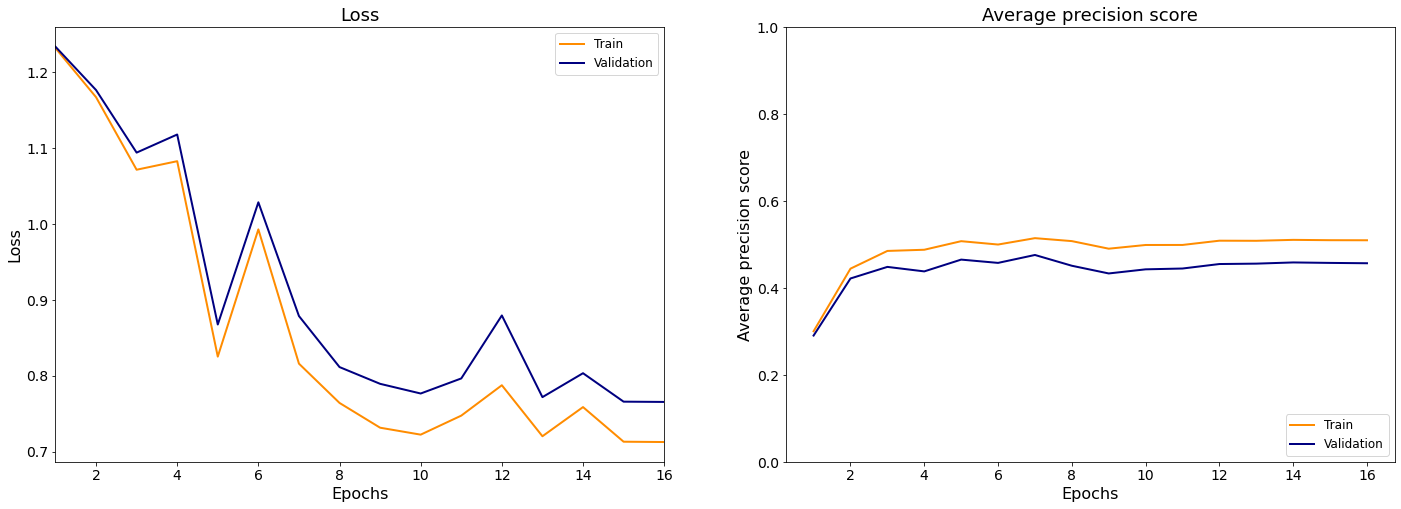

In [48]:
fig, axs = plt.subplots(1, 2, figsize=(24, 8))

lw = 2

x_train_loss = np.linspace(1, epochs, len(history['train_loss']))

axs[0].plot(x_train_loss, history['train_loss'], color='darkorange', lw=lw, label='Train')
axs[0].plot(np.linspace(1, epochs, len(history['val_loss'])), history['val_loss'], color='navy', lw=lw, label='Validation')
axs[0].set_xlabel('Epochs', fontdict={'size': 16})
axs[0].set_ylabel('Loss', fontdict={'size': 16})
axs[0].set_xlim(1, epochs)
axs[0].set_title('Loss', fontdict={'size': 18})
axs[0].legend(loc="upper right", prop={'size': 12})
axs[0].tick_params(axis='both', which='major', labelsize=14)

x_train_auc = np.linspace(1, epochs, len(history['train_ap']))

axs[1].plot(x_train_auc, history['train_ap'], color='darkorange', lw=lw, label='Train')
axs[1].plot(np.linspace(1, epochs, len(history['val_ap'])), history['val_ap'], color='navy', lw=lw, label='Validation')
axs[1].set_xlabel('Epochs', fontdict={'size': 16})
axs[1].set_ylabel('Average precision score', fontdict={'size': 16})
axs[1].set_ylim(0.0, 1.0)
axs[0].set_xlim(1, epochs)
axs[1].set_title('Average precision score', fontdict={'size': 18})
axs[1].legend(loc="lower right", prop={'size': 12})
axs[1].tick_params(axis='both', which='major', labelsize=14)

plt.show()

Optimal threshold value is computed using precision, recall and theshold values.
This value will be used for validation and test sets.

In addition, F1 score is also calculated.

In [49]:
precision, recall, thresholds = pr_curve

f1_score = (2 * precision * recall) / (precision + recall)

optimal_idx = np.argmax(f1_score)
optimal_threshold = thresholds[optimal_idx]

Precision-Recall Curve is plotted. AP score approaches a value of 0.5 for the validation set.

In [54]:
def plot_precision_recall_curve(precision: np.ndarray,
                                recall: np.ndarray,
                                thresholds: np.ndarray,
                                ap_score: np.float64,
                                title: str,
                                optimal_threshold: Optional[np.float64]=None):
    fig, ax = plt.subplots(figsize=(12, 8))
    lw = 2
    if optimal_threshold:
        ax.annotate(f'Optimal threshold = {optimal_threshold:.4f}',
                    xy=(recall[optimal_idx], precision[optimal_idx]),
                    xytext=(0.7, 0.5),
                    arrowprops=dict(arrowstyle="->"),
                    horizontalalignment='right', verticalalignment='top', size=10)
    plt.plot(recall, precision, color='darkorange', lw=lw, label=f'Average precision score = {ap_score:.4f}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontdict={'size': 16})
    plt.ylabel('Precision', fontdict={'size': 16})
    plt.title(title, fontdict={'size': 18})
    plt.legend(loc="lower right", prop={'size': 12})
    ax.tick_params(axis='both', which='major', labelsize=14)

    plt.show()

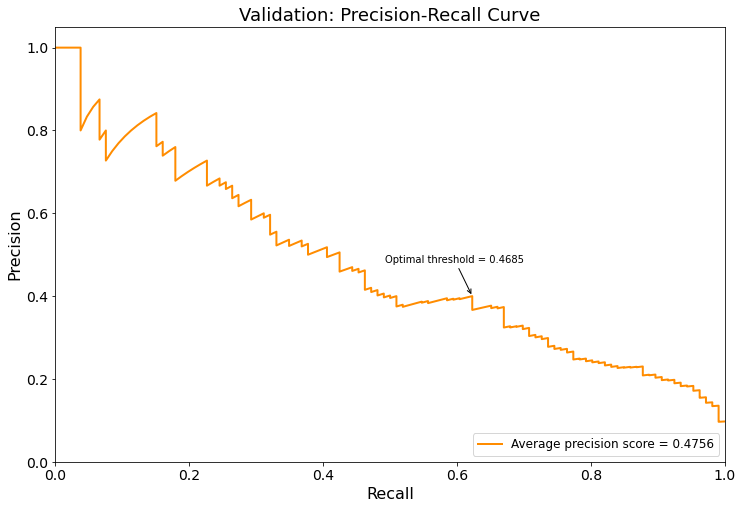

In [55]:
plot_precision_recall_curve(precision=precision,
                            recall=recall,
                            thresholds=thresholds,
                            title='Validation: Precision-Recall Curve',
                            optimal_threshold=optimal_threshold,
                            ap_score=history['best_val_ap'])

In [56]:
print(f'Validation:\n - Precision: {precision[optimal_idx]:.4f}\n - Recall: {recall[optimal_idx]:.4f}\n - Average precision: {history["best_val_ap"]:.4f}\n - F1 score: {f1_score[optimal_idx]:.4f}')

Validation:
 - Precision: 0.4000
 - Recall: 0.6226
 - Average precision: 0.4756
 - F1 score: 0.4871


# Evaluation

Finally, test set is evaluated. We are doing a similar procedure that what we did for the validation set, the only different is that we do not calculate a new "optimal threshold" for the test set, we just use the "optimal threshold" obtained on the validation set.

In [57]:
_, test_ap, test_pr_curve, test_pred_probs, test_true_labels = test(model=model,
                                                                    device=device,
                                                                    dataloader=test_dataloader,
                                                                    dataset_size=dataset_sizes['test'])

test_precision, test_recall, test_thresholds = test_pr_curve
test_f1_score = (2 * test_precision * test_recall) / (test_precision + test_recall)

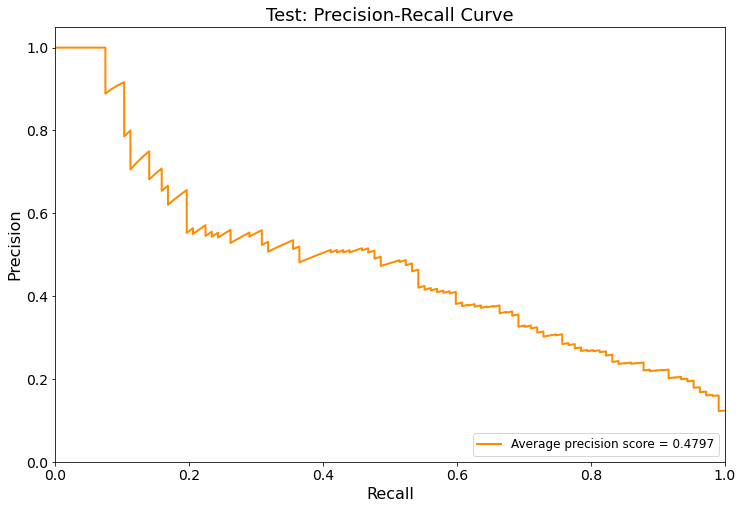

In [58]:
plot_precision_recall_curve(precision=test_precision,
                            recall=test_recall,
                            thresholds=test_thresholds,
                            title='Test: Precision-Recall Curve',
                            ap_score=test_ap)

In [63]:
test_pred_labels = test_pred_probs > optimal_threshold
cm = confusion_matrix(test_true_labels, test_pred_labels)

In [72]:
test_precision_threshold = cm[1, 1] / (cm[1, 1] + cm[0, 1])
test_recall_threshold = cm[1, 1] / (cm[1, 1] + cm[1, 0])


test_f1_score_threshold = (2 * test_precision_threshold * test_recall_threshold) / (test_precision_threshold + test_recall_threshold)

In [73]:
print(f'Test:\n - Precision: {test_precision_threshold:.4f}\n - Recall: {test_recall_threshold:.4f}\n - Average precision: {test_ap:.4f}\n - F1 score: {test_f1_score_threshold:.4f}')

Test:
 - Precision: 0.3824
 - Recall: 0.6075
 - Average precision: 0.4797
 - F1 score: 0.4693


Confusion matrix with the predicted values is plotted. We can see that the majority of the wrong predictions come from the false positives predicted by the model.

Text(0.5, 1.0, 'Confusion Matrix')

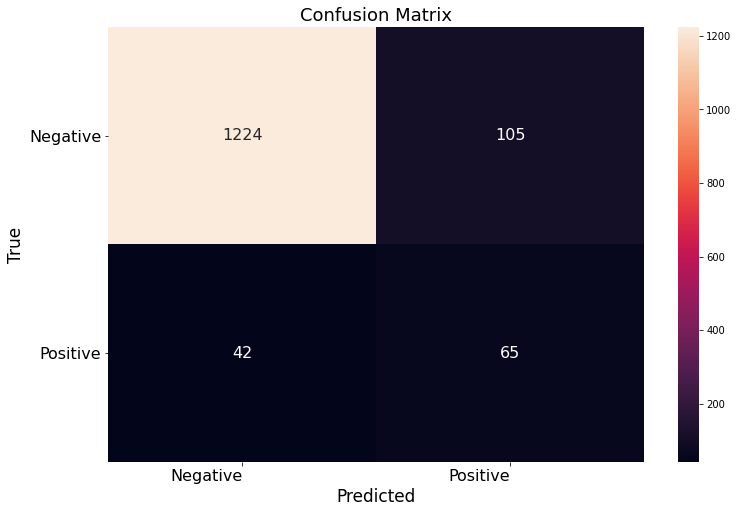

In [74]:
labels = ['Negative', 'Positive']

fig, ax = plt.subplots(figsize=(12, 8))
heatmap = sns.heatmap(cm, annot=True, fmt='g', annot_kws={"size": 16})
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=16)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right', fontsize=16)
ax.xaxis.set_ticklabels(labels)
ax.yaxis.set_ticklabels(labels)
plt.ylabel('True', fontdict={'size': 17})
plt.xlabel('Predicted', fontdict={'size': 17})
plt.title('Confusion Matrix', fontdict={'size': 18})

Finally, a csv with the sentences, true labels and predicted probabilites is generated.

In [65]:
df = pd.DataFrame({'text_es': X_test['text_es'],
                   'label': y_test,
                   'pred': test_pred_probs})
df.to_csv('/tmp/test_pred_JaimeCespedesSisniega.csv',
          index=False)

# Conclusions

We can indicate that the precision of pointing out a sentence as verifiable is a complex task using a reduced set of data, as it is the case, since in the confusion matrix of the test set we can see how a relatively high amount of false positives are produced.

In the tests carried out, only one type of model has been tested and no hyperparameter tuning has been made. The use of several models or carryng out an adequate hyperparameter tuning phase could have a positive impact on the metrics used, as well as a higher computational cost.

# **References**

[1] Conneau, Alexis, et al. "Unsupervised cross-lingual representation learning at scale." arXiv preprint arXiv:1911.02116 (2019).

[2] Loshchilov, Ilya, and Frank Hutter. "Decoupled weight decay regularization." arXiv preprint arXiv:1711.05101 (2017).

[3] Smith, Leslie N., and Nicholay Topin. "Super-convergence: Very fast training of neural networks using large learning rates." Artificial Intelligence and Machine Learning for Multi-Domain Operations Applications. Vol. 11006. International Society for Optics and Photonics, 2019.